In [3]:
import os
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt
import time
import optuna

In [4]:
device = ("cuda" if torch.cuda.is_available()
         else "mps" if torch.mps.is_available()
         else "cpu")
device


'mps'

# Load Data

In [5]:
image_transfroms = transforms.Compose([
    # data Augumentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean= [0.485, 0.456, 0.406], std = [0.229,0.224, 0.225 ]) #these are the mean , std for imageNet data 
    # Since we are using Transfer Learning from Resnet or other Efficient net as those nets are train on imageNet
])

In [6]:
dataset_path = "./dataset"
dataset = datasets.ImageFolder(root = dataset_path, transform = image_transfroms )
len(dataset)

2300

In [7]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [8]:
num_classes = len(dataset.classes)
num_classes

6

In [9]:
train_size = int(0.75* len(dataset))
val_size = len(dataset) - train_size
train_size, val_size

(1725, 575)

In [10]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [11]:
# DataLoader 

train_loader =  DataLoader(train_dataset, batch_size= 32, shuffle= True)
val_loader =  DataLoader(val_dataset, batch_size= 32, shuffle= True)

In [12]:
# Checking the size
for images , labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [13]:
images[0].shape

torch.Size([3, 224, 224])

In [14]:
images[0].permute(1,2, 0 ).shape

torch.Size([224, 224, 3])

In [15]:
labels[0]

tensor(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


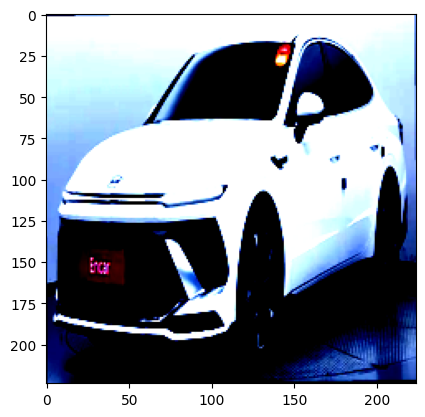

In [16]:
plt.imshow(images[0].permute(1,2, 0 )) # expects [224 , 224 , 3] not in [3, 244, 244]
plt.show()

In [17]:
# car classifier 
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3 , stride=1 , padding=1 ), # (16, 244, 244)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (16, 122, 122)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3 , stride=1 , padding=1 ), # (32, 122, 122)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (32, 56, 56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3 , stride=1 , padding=1 ), # (64, 56, 56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (64, 28, 28)

            nn.Flatten(),

            # FCN 
            nn.Linear(64*28*28 , 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            
            
            
        )

    def forward(self, x):
        x = self.network(x)
        return x


# Model 1

In [18]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            if (batch_num+1) % 10 == 0:
                print(f"Batch: {batch_num+1}, Epoch: {epoch+1}, Loss: {loss.item():0.2f}")
            
            running_loss += loss.item() * images.size(0)
            
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        all_labels = []
        all_predictions = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data,1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())
                
            print(f"*** Validation Accuracy: {100 * correct / total:.2f}% ***")
            
    end = time.time()
    print(f"Execution time: {end - start} seconds")     
    
    return all_labels, all_predictions

In [19]:
# car classifier 
class CarClassifierCNNwithRegularization(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3 , stride=1 , padding=1 ), # (16, 244, 244)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (16, 122, 122)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3 , stride=1 , padding=1 ), # (32, 122, 122)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (32, 56, 56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3 , stride=1 , padding=1 ), # (64, 56, 56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),                                 # (64, 28, 28)

            nn.Flatten(),

            # FCN 
            nn.Linear(64*28*28 , 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
            
            
            
        )

    def forward(self, x):
        x = self.network(x)
        return x


In [20]:
model = CarClassifierCNNwithRegularization(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

all_labels, all_predictions = train_model(model, criterion, optimizer,  epochs=5)

Batch: 10, Epoch: 1, Loss: 12.79
Batch: 20, Epoch: 1, Loss: 5.62
Batch: 30, Epoch: 1, Loss: 2.54
Batch: 40, Epoch: 1, Loss: 1.72
Batch: 50, Epoch: 1, Loss: 1.72
Epoch [1/5], Avg Loss: 5.7274
*** Validation Accuracy: 45.57% ***
Batch: 10, Epoch: 2, Loss: 1.46
Batch: 20, Epoch: 2, Loss: 1.76
Batch: 30, Epoch: 2, Loss: 1.19
Batch: 40, Epoch: 2, Loss: 1.64
Batch: 50, Epoch: 2, Loss: 1.11
Epoch [2/5], Avg Loss: 1.3519
*** Validation Accuracy: 48.17% ***
Batch: 10, Epoch: 3, Loss: 1.18
Batch: 20, Epoch: 3, Loss: 0.99
Batch: 30, Epoch: 3, Loss: 1.17
Batch: 40, Epoch: 3, Loss: 1.03
Batch: 50, Epoch: 3, Loss: 1.08
Epoch [3/5], Avg Loss: 1.2254
*** Validation Accuracy: 54.43% ***
Batch: 10, Epoch: 4, Loss: 1.26
Batch: 20, Epoch: 4, Loss: 0.92
Batch: 30, Epoch: 4, Loss: 1.12
Batch: 40, Epoch: 4, Loss: 1.21
Batch: 50, Epoch: 4, Loss: 1.15
Epoch [4/5], Avg Loss: 1.1793
*** Validation Accuracy: 52.52% ***
Batch: 10, Epoch: 5, Loss: 1.11
Batch: 20, Epoch: 5, Loss: 1.11
Batch: 30, Epoch: 5, Loss: 0.93

In [21]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [22]:
class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x              

In [23]:
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.72
Batch: 20, Epoch: 1, Loss: 1.55
Batch: 30, Epoch: 1, Loss: 1.49
Batch: 40, Epoch: 1, Loss: 1.45
Batch: 50, Epoch: 1, Loss: 1.20
Epoch [1/10], Avg Loss: 1.4903
*** Validation Accuracy: 61.22% ***
Batch: 10, Epoch: 2, Loss: 1.13
Batch: 20, Epoch: 2, Loss: 1.23
Batch: 30, Epoch: 2, Loss: 1.35
Batch: 40, Epoch: 2, Loss: 1.15
Batch: 50, Epoch: 2, Loss: 1.17
Epoch [2/10], Avg Loss: 1.1700
*** Validation Accuracy: 63.13% ***
Batch: 10, Epoch: 3, Loss: 1.00
Batch: 20, Epoch: 3, Loss: 1.12
Batch: 30, Epoch: 3, Loss: 1.01
Batch: 40, Epoch: 3, Loss: 0.85
Batch: 50, Epoch: 3, Loss: 0.90
Epoch [3/10], Avg Loss: 1.0361
*** Validation Accuracy: 63.13% ***
Batch: 10, Epoch: 4, Loss: 0.89
Batch: 20, Epoch: 4, Loss: 0.71
Batch: 30, Epoch: 4, Loss: 0.96
Batch: 40, Epoch: 4, Loss: 0.80
Batch: 50, Epoch: 4, Loss: 1.08
Epoch [4/10], Avg Loss: 0.9509
*** Validation Accuracy: 65.91% ***
Batch: 10, Epoch: 5, Loss: 0.82
Batch: 20, Epoch: 5, Loss: 0.88
Batch: 30, Epoch: 5, Loss: 0

### Model 4: Transfer Learning with ResNet

In [24]:
# Load the pre-trained ResNet model
class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze layer4 and fc layers
        for param in self.model.layer4.parameters():
            param.requires_grad = True            
            
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_classes)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [25]:
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

labels, predictions = train_model(model, criterion, optimizer, epochs=10)

Batch: 10, Epoch: 1, Loss: 1.13
Batch: 20, Epoch: 1, Loss: 0.63
Batch: 30, Epoch: 1, Loss: 0.65
Batch: 40, Epoch: 1, Loss: 0.67
Batch: 50, Epoch: 1, Loss: 1.01
Epoch [1/10], Avg Loss: 0.8750
*** Validation Accuracy: 72.87% ***
Batch: 10, Epoch: 2, Loss: 0.49
Batch: 20, Epoch: 2, Loss: 0.37
Batch: 30, Epoch: 2, Loss: 0.33
Batch: 40, Epoch: 2, Loss: 0.74
Batch: 50, Epoch: 2, Loss: 0.50
Epoch [2/10], Avg Loss: 0.4641
*** Validation Accuracy: 74.96% ***
Batch: 10, Epoch: 3, Loss: 0.40
Batch: 20, Epoch: 3, Loss: 0.62
Batch: 30, Epoch: 3, Loss: 0.26
Batch: 40, Epoch: 3, Loss: 0.16
Batch: 50, Epoch: 3, Loss: 0.77
Epoch [3/10], Avg Loss: 0.3539
*** Validation Accuracy: 74.09% ***
Batch: 10, Epoch: 4, Loss: 0.14
Batch: 20, Epoch: 4, Loss: 0.24
Batch: 30, Epoch: 4, Loss: 0.31
Batch: 40, Epoch: 4, Loss: 0.25
Batch: 50, Epoch: 4, Loss: 0.35
Epoch [4/10], Avg Loss: 0.2509
*** Validation Accuracy: 79.30% ***
Batch: 10, Epoch: 5, Loss: 0.16
Batch: 20, Epoch: 5, Loss: 0.04
Batch: 30, Epoch: 5, Loss: 0

In [26]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    
    # Load the model
    model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    # Training loop (using fewer epochs for faster hyperparameter tuning)
    epochs = 3
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        
        # Report intermediate result to Optuna
        trial.report(accuracy, epoch)
        
        # Handle pruning (if applicable)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start} seconds")
    
    return accuracy

In [27]:
# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2025-06-11 19:34:34,037] A new study created in memory with name: no-name-5fde6c8f-6409-41b9-8c4d-bc129a99b623
[I 2025-06-11 19:37:17,677] Trial 0 finished with value: 77.56521739130434 and parameters: {'lr': 0.00025883513612924775, 'dropout_rate': 0.5219974492774537}. Best is trial 0 with value: 77.56521739130434.


Execution time: 163.24363493919373 seconds


[I 2025-06-11 19:40:01,634] Trial 1 finished with value: 78.43478260869566 and parameters: {'lr': 0.00034599184713467987, 'dropout_rate': 0.35807258727954555}. Best is trial 1 with value: 78.43478260869566.


Execution time: 163.58374500274658 seconds


[I 2025-06-11 19:42:44,888] Trial 2 finished with value: 77.56521739130434 and parameters: {'lr': 0.001035458302572843, 'dropout_rate': 0.2648472506566282}. Best is trial 1 with value: 78.43478260869566.


Execution time: 162.89064693450928 seconds


[I 2025-06-11 19:45:32,515] Trial 3 finished with value: 49.56521739130435 and parameters: {'lr': 1.3053960218523072e-05, 'dropout_rate': 0.3565005077290421}. Best is trial 1 with value: 78.43478260869566.


Execution time: 167.2511761188507 seconds


[I 2025-06-11 19:48:27,214] Trial 4 finished with value: 74.6086956521739 and parameters: {'lr': 5.708128444581881e-05, 'dropout_rate': 0.45941238138072}. Best is trial 1 with value: 78.43478260869566.


Execution time: 174.32424020767212 seconds


[I 2025-06-11 19:49:22,021] Trial 5 pruned. 
[I 2025-06-11 19:50:16,453] Trial 6 pruned. 
[I 2025-06-11 19:51:10,619] Trial 7 pruned. 
[I 2025-06-11 19:52:05,683] Trial 8 pruned. 
[I 2025-06-11 19:52:59,700] Trial 9 pruned. 
[I 2025-06-11 19:53:54,471] Trial 10 pruned. 
[I 2025-06-11 19:54:50,551] Trial 11 pruned. 
[I 2025-06-11 19:55:45,172] Trial 12 pruned. 
[I 2025-06-11 19:56:39,136] Trial 13 pruned. 
[I 2025-06-11 19:57:33,198] Trial 14 pruned. 
[I 2025-06-11 19:58:35,382] Trial 15 pruned. 
[I 2025-06-11 19:59:41,876] Trial 16 pruned. 
[I 2025-06-11 20:00:36,040] Trial 17 pruned. 
[I 2025-06-11 20:01:32,097] Trial 18 pruned. 
[I 2025-06-11 20:02:25,957] Trial 19 pruned. 
